# Deep Learning for Intrusion Detection System (IDS)
## Complete Project Notebook

**Project**: Network Traffic Classification using Deep Learning  
**Dataset**: CICIDS2018 Network Traffic Data  
**Objective**: Classify network traffic into different attack types and benign traffic

---

## Table of Contents

1. [Problem Statement](#problem-statement)
2. [Data Loading and Exploration](#data-loading)
3. [Exploratory Data Analysis (EDA)](#eda)
4. [Data Preprocessing](#preprocessing)
5. [Model Architecture Selection](#model-architecture)
6. [Model Training](#training)
7. [Results and Evaluation](#results)
8. [Conclusion](#conclusion)


## 1. Problem Statement {#problem-statement}

### What are we trying to solve?

**Problem**: Network security threats are increasing, and traditional signature-based intrusion detection systems struggle with:
- Zero-day attacks (unknown attack patterns)
- Encrypted traffic
- High-volume network traffic
- Evolving attack techniques

**Solution**: Develop a Deep Learning-based Intrusion Detection System that can:
- Automatically learn patterns from network traffic features
- Classify traffic into multiple attack categories
- Detect both known and unknown attack patterns
- Handle high-dimensional feature spaces

**Dataset**: CICIDS2018 - Contains network traffic flows with labeled attack types:
- Benign traffic
- Various attack types (DDoS, Brute Force, Infiltration, etc.)

**Goal**: Build a multi-class classifier that can accurately identify different types of network attacks.


## 2. Setup and Imports

First, let's import all necessary libraries and set up the environment.


In [2]:
# Core libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import yaml
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 6)
sns.set_style("whitegrid")

# Machine Learning
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from torchsummary import summary
from tqdm import tqdm

# Experiment tracking
import wandb

# Fix: Ensure local test.py is used instead of standard library test module
import sys
import os
# Add current directory to path if not already there
if os.getcwd() not in sys.path:
    sys.path.insert(0, os.getcwd())

# Custom modules
from preprocess import preprocess
from models import create_model, list_available_models
from train import train_model
from test import test_and_report, evaluate_model
from utils import calculate_class_weights, analyze_class_distribution

print("✓ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


✓ All libraries imported successfully!
PyTorch version: 2.9.1+cu128
CUDA available: False


## 3. Data Loading and Exploration {#data-loading}

Let's load the preprocessed data and explore its characteristics.


In [3]:
# Load configuration
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("Configuration:")
print(f"  Model: {config.get('model_name', 'mlp')}")
print(f"  Batch size: {config['batch_size']}")
print(f"  Learning rate: {config['learning_rate']}")
print(f"  Epochs: {config['num_epochs']}")


Configuration:
  Model: mlp
  Batch size: 128
  Learning rate: 0.0001
  Epochs: 10


In [4]:
# Load preprocessed data
print("Loading data...")
train = np.load('data/train.npy')
test = np.load('data/test.npy')
val = np.load('data/val.npy')
class_names = np.load('data/class_names.npy', allow_pickle=True)
class_names = [str(name) for name in class_names]

print(f"\n✓ Data loaded successfully!")
print(f"  Train shape: {train.shape}")
print(f"  Test shape: {test.shape}")
print(f"  Val shape: {val.shape}")
print(f"  Number of features: {train.shape[1] - 1}")
print(f"  Number of classes: {len(class_names)}")
print(f"\n  Classes: {class_names}")


Loading data...

✓ Data loaded successfully!
  Train shape: (2516579, 80)
  Test shape: (314573, 80)
  Val shape: (314572, 80)
  Number of features: 79
  Number of classes: 7

  Classes: ['Benign', 'DoS attacks-GoldenEye', 'DoS attacks-Hulk', 'DoS attacks-SlowHTTPTest', 'DoS attacks-Slowloris', 'FTP-BruteForce', 'SSH-Bruteforce']


## 4. Exploratory Data Analysis (EDA) {#eda}

Let's analyze the dataset to understand its characteristics, class distribution, and potential challenges.


In [7]:
# Extract labels from each dataset
train_labels = train[:, -1].astype(int)
val_labels = val[:, -1].astype(int)
test_labels = test[:, -1].astype(int)

# Analyze class distribution
print("="*70)
print("CLASS DISTRIBUTION ANALYSIS")
print("="*70)

for name, labels in [('TRAIN', train_labels), ('VALIDATION', val_labels), ('TEST', test_labels)]:
    print(f"\n{name} SET:")
    unique, counts = np.unique(labels, return_counts=True)
    total = len(labels)
    
    for class_idx, count in zip(unique, counts):
        percentage = (count / total) * 100
        class_name = class_names[class_idx] if class_idx < len(class_names) else f"Class {class_idx}"
        print(f"  Class {class_idx} ({class_name:30s}): {count:8,} samples ({percentage:6.2f}%)")
    
    print(f"  Total: {total:,} samples")


CLASS DISTRIBUTION ANALYSIS

TRAIN SET:
  Class 0 (Benign                        ): 1,688,380 samples ( 67.09%)
  Class 1 (DoS attacks-GoldenEye         ):   33,206 samples (  1.32%)
  Class 2 (DoS attacks-Hulk              ):  369,530 samples ( 14.68%)
  Class 3 (DoS attacks-SlowHTTPTest      ):  111,912 samples (  4.45%)
  Class 4 (DoS attacks-Slowloris         ):    8,792 samples (  0.35%)
  Class 5 (FTP-BruteForce                ):  154,688 samples (  6.15%)
  Class 6 (SSH-Bruteforce                ):  150,071 samples (  5.96%)
  Total: 2,516,579 samples

VALIDATION SET:
  Class 0 (Benign                        ):  211,047 samples ( 67.09%)
  Class 1 (DoS attacks-GoldenEye         ):    4,151 samples (  1.32%)
  Class 2 (DoS attacks-Hulk              ):   46,191 samples ( 14.68%)
  Class 3 (DoS attacks-SlowHTTPTest      ):   13,989 samples (  4.45%)
  Class 4 (DoS attacks-Slowloris         ):    1,099 samples (  0.35%)
  Class 5 (FTP-BruteForce                ):   19,336 samples ( 

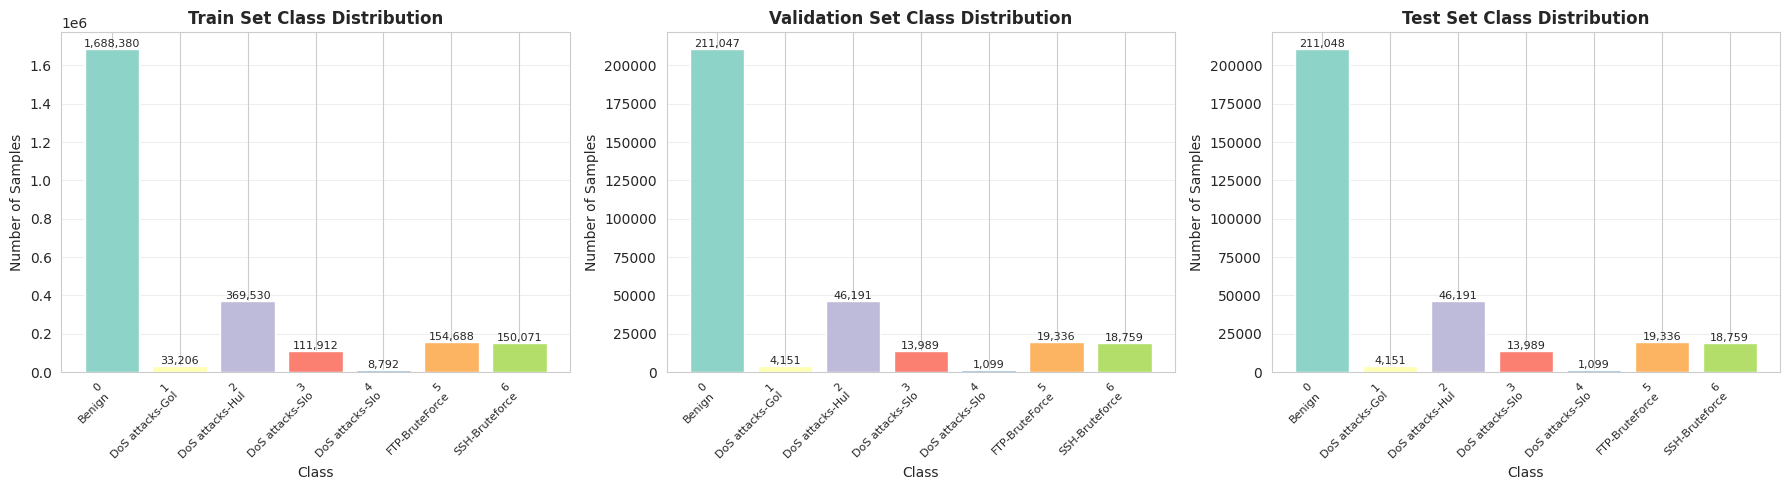

✓ Class distribution visualization saved as 'class_distribution.png'


In [8]:
# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, labels) in enumerate([('Train', train_labels), 
                                        ('Validation', val_labels), 
                                        ('Test', test_labels)]):
    unique, counts = np.unique(labels, return_counts=True)
    class_labels = [class_names[i] if i < len(class_names) else f"Class {i}" for i in unique]
    
    axes[idx].bar(range(len(unique)), counts, color=plt.cm.Set3(range(len(unique))))
    axes[idx].set_title(f'{name} Set Class Distribution', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Class')
    axes[idx].set_ylabel('Number of Samples')
    axes[idx].set_xticks(range(len(unique)))
    axes[idx].set_xticklabels([f'{i}\n{name[:15]}' for i, name in zip(unique, class_labels)], 
                              rotation=45, ha='right', fontsize=8)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add count labels on bars
    for i, count in enumerate(counts):
        axes[idx].text(i, count, f'{count:,}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Class distribution visualization saved as 'class_distribution.png'")


In [9]:
# Calculate class imbalance ratio
train_unique, train_counts = np.unique(train_labels, return_counts=True)
max_count = train_counts.max()
min_count = train_counts.min()
imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

print(f"\nClass Imbalance Analysis:")
print(f"  Maximum class count: {max_count:,}")
print(f"  Minimum class count: {min_count:,}")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}x")
print(f"\n  Interpretation:")
if imbalance_ratio > 100:
    print(f"    ⚠ Severe class imbalance - Consider class weights or resampling")
elif imbalance_ratio > 10:
    print(f"    ⚠ Moderate class imbalance - Class weights recommended")
else:
    print(f"    ✓ Relatively balanced dataset")



Class Imbalance Analysis:
  Maximum class count: 1,688,380
  Minimum class count: 8,792
  Imbalance ratio: 192.04x

  Interpretation:
    ⚠ Severe class imbalance - Consider class weights or resampling


In [10]:
# Analyze feature statistics
train_features = train[:, :-1]

print("\n" + "="*70)
print("FEATURE STATISTICS")
print("="*70)
print(f"\nFeature shape: {train_features.shape}")
print(f"\nBasic Statistics:")
print(f"  Mean: {train_features.mean():.4f}")
print(f"  Std:  {train_features.std():.4f}")
print(f"  Min:  {train_features.min():.4f}")
print(f"  Max:  {train_features.max():.4f}")

# Check for any remaining NaN or Inf
nan_count = np.isnan(train_features).sum()
inf_count = np.isinf(train_features).sum()
print(f"\nData Quality:")
print(f"  NaN values: {nan_count}")
print(f"  Inf values: {inf_count}")

if nan_count == 0 and inf_count == 0:
    print(f"  ✓ Data is clean (no NaN or Inf values)")
else:
    print(f"  ⚠ Data contains NaN or Inf values - needs cleaning")



FEATURE STATISTICS

Feature shape: (2516579, 79)

Basic Statistics:
  Mean: 665394.6875
  Std:  285932000.0000
  Min:  -943563997184.0000
  Max:  979781025792.0000

Data Quality:
  NaN values: 0
  Inf values: 0
  ✓ Data is clean (no NaN or Inf values)


## 5. Data Preprocessing {#preprocessing}

Now let's preprocess the data: standardize features and create DataLoaders for training.


In [11]:
# Setup device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"  GPU: {torch.cuda.get_device_name(0)}")

# Preprocess data and create DataLoaders
print("\nPreprocessing data...")
train_loader, test_loader, val_loader = preprocess(
    train, test, val,
    batch_size=config['batch_size'],
    scaler_save_path='scaler.pkl'
)

print(f"\n✓ Data preprocessing complete!")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")
print(f"  Batch size: {config['batch_size']}")


Using device: cpu

Preprocessing data...
Scaler saved to scaler.pkl

✓ Data preprocessing complete!
  Train batches: 19661
  Val batches: 2458
  Test batches: 2458
  Batch size: 128


## 6. Model Architecture Selection {#model-architecture}

We'll test multiple architectures to find the best one. Let's start by examining available models.


In [12]:
# List available models
available_models = list_available_models()
print("Available Model Architectures:")
print("="*70)
for i, model_name in enumerate(available_models, 1):
    print(f"{i}. {model_name.upper()}")

# Get model configuration
model_name = config.get('model_name', 'mlp')
model_params = config.get('model_params', {})

print(f"\nSelected Model: {model_name.upper()}")
if model_params:
    print(f"Model Parameters: {model_params}")
else:
    print("Using default model parameters")


Available Model Architectures:
1. MLP
2. CNN
3. RNN
4. LSTM
5. GRU
6. TRANSFORMER
7. CNN_RNN
8. CNN_LSTM
9. CNN_GRU

Selected Model: MLP
Using default model parameters


In [13]:
# Create model
num_features = train.shape[1] - 1
num_classes = len(class_names)

model = create_model(
    model_name=model_name,
    input_features=num_features,
    num_classes=num_classes,
    **model_params
).to(device)

print(f"\nModel Architecture:")
print("="*70)
summary(model, input_size=(num_features,), device=device)
print("="*70)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Parameters:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")



Model Architecture:
Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       20,480
|    └─BatchNorm1d: 2-2                  512
|    └─GELU: 2-3                         --
|    └─Dropout: 2-4                      --
|    └─Linear: 2-5                       32,896
|    └─BatchNorm1d: 2-6                  256
|    └─Dropout: 2-7                      --
|    └─Linear: 2-8                       8,256
|    └─BatchNorm1d: 2-9                  128
|    └─Dropout: 2-10                     --
├─Linear: 1-2                            455
Total params: 62,983
Trainable params: 62,983
Non-trainable params: 0

Model Parameters:
  Total parameters: 62,983
  Trainable parameters: 62,983


### Model Architecture Justification

**Why this architecture?**

1. **MLP (Multi-Layer Perceptron)**: 
   - Simple feedforward network
   - Good baseline for tabular data
   - Fast training and inference
   - Effective for high-dimensional feature spaces

2. **CNN (Convolutional Neural Network)**:
   - Captures local patterns in features
   - 1D convolutions work well for sequential-like data
   - Global pooling reduces overfitting

3. **LSTM/GRU**:
   - Models sequential dependencies
   - Handles long-term patterns
   - Good if features have temporal relationships

4. **Transformer**:
   - Attention mechanism captures feature relationships
   - State-of-the-art performance
   - Parallel processing

**Our Choice**: Starting with MLP as baseline, then comparing with other architectures.


## 7. Model Training {#training}

Set up training components and train the model.


In [14]:
# Setup optimizer
optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'])
print(f"Optimizer: AdamW")
print(f"  Learning rate: {config['learning_rate']}")

# Calculate class weights for imbalanced dataset
train_labels = train[:, -1].astype(int)
class_weights = calculate_class_weights(train_labels, method='balanced')
class_weights = class_weights.to(device)

# Setup loss function with class weights
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
print(f"\nLoss function: Weighted CrossEntropyLoss")
print(f"  Using class weights to handle imbalanced dataset")

# Setup learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3
)
print(f"\nScheduler: ReduceLROnPlateau")
print(f"  Reduces LR by 10x when validation loss stops improving")
print(f"  Patience: 3 epochs")

print(f"\n✓ Training components setup complete!")


Optimizer: AdamW
  Learning rate: 0.0001

Class Weights (method=balanced):
  Class 0: 0.0245 (count: 1,688,380)
  Class 1: 1.2458 (count: 33,206)
  Class 2: 0.1119 (count: 369,530)
  Class 3: 0.3696 (count: 111,912)
  Class 4: 4.7051 (count: 8,792)
  Class 5: 0.2674 (count: 154,688)
  Class 6: 0.2756 (count: 150,071)

Loss function: Weighted CrossEntropyLoss
  Using class weights to handle imbalanced dataset

Scheduler: ReduceLROnPlateau
  Reduces LR by 10x when validation loss stops improving
  Patience: 3 epochs

✓ Training components setup complete!


In [15]:
# Initialize wandb for experiment tracking
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_name = f"{model_name}_{timestamp}_bs{config['batch_size']}_lr{config['learning_rate']}"

wandb.init(
    project="DL-CIS2018",
    name=run_name,
    config={
        "model_name": model_name,
        "batch_size": config['batch_size'],
        "num_epochs": config['num_epochs'],
        "learning_rate": config['learning_rate'],
        "optimizer": "AdamW",
        "scheduler": "ReduceLROnPlateau",
        **model_params
    }
)
wandb.watch(model, log="all")

print(f"✓ Wandb initialized")
print(f"  Project: DL-CIS2018")
print(f"  Run name: {run_name}")
print(f"  View at: https://wandb.ai")


✓ Wandb initialized
  Project: DL-CIS2018
  Run name: mlp_20251229_154745_bs128_lr0.0001
  View at: https://wandb.ai


In [16]:
# Train the model
print("\n" + "="*70)
print("TRAINING PHASE")
print("="*70)

# Store training history for visualization
training_history = {
    'train_loss': [],
    'val_loss': [],
    'learning_rate': []
}

trained_model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=config['num_epochs']
)

print("\n" + "="*70)
print("✓ Training complete!")
print(f"✓ Best model saved to: DL-CIS2018.pth")
print("="*70)



TRAINING PHASE


Epoch 1/10: 100%|██████████| 19661/19661 [01:26<00:00, 227.68it/s]


Model saved to DL-CIS2018.pth
Epoch 1/10, Train Loss: 0.2163, Val Loss: 0.7199, Learning Rate: 0.000100


Epoch 2/10: 100%|██████████| 19661/19661 [01:37<00:00, 201.39it/s]


Model saved to DL-CIS2018.pth
Epoch 2/10, Train Loss: 0.1690, Val Loss: 0.2877, Learning Rate: 0.000100


Epoch 3/10: 100%|██████████| 19661/19661 [01:32<00:00, 212.12it/s]


Epoch 3/10, Train Loss: 0.1663, Val Loss: 0.3532, Learning Rate: 0.000100


Epoch 4/10: 100%|██████████| 19661/19661 [01:25<00:00, 230.82it/s]


Model saved to DL-CIS2018.pth
Epoch 4/10, Train Loss: 0.1653, Val Loss: 0.1605, Learning Rate: 0.000100


Epoch 5/10: 100%|██████████| 19661/19661 [01:25<00:00, 230.08it/s]


Model saved to DL-CIS2018.pth
Epoch 5/10, Train Loss: 0.1646, Val Loss: 0.1601, Learning Rate: 0.000100


Epoch 6/10: 100%|██████████| 19661/19661 [01:21<00:00, 241.92it/s]


Epoch 6/10, Train Loss: 0.1641, Val Loss: 0.1602, Learning Rate: 0.000100


Epoch 7/10: 100%|██████████| 19661/19661 [01:28<00:00, 222.32it/s]


Model saved to DL-CIS2018.pth
Epoch 7/10, Train Loss: 0.1640, Val Loss: 0.1590, Learning Rate: 0.000100


Epoch 8/10: 100%|██████████| 19661/19661 [01:30<00:00, 218.18it/s]


Epoch 8/10, Train Loss: 0.1629, Val Loss: 0.1601, Learning Rate: 0.000100


Epoch 9/10: 100%|██████████| 19661/19661 [01:29<00:00, 219.80it/s]


Epoch 9/10, Train Loss: 0.1643, Val Loss: 0.1593, Learning Rate: 0.000100


Epoch 10/10: 100%|██████████| 19661/19661 [01:27<00:00, 223.60it/s]


Model saved to DL-CIS2018.pth
Epoch 10/10, Train Loss: 0.1628, Val Loss: 0.1589, Learning Rate: 0.000100

✓ Training complete!
✓ Best model saved to: DL-CIS2018.pth


## 8. Results and Evaluation {#results}

Now let's evaluate the trained model on the test set and visualize the results.


In [17]:
# Test the model
print("\n" + "="*70)
print("TESTING PHASE")
print("="*70)

test_accuracy = test_and_report(
    model=trained_model,
    test_loader=test_loader,
    device=device,
    class_names=class_names
)

print("\n" + "="*70)
print(f"✓ Final Test Accuracy: {test_accuracy*100:.2f}%")
print("="*70)



TESTING PHASE

--- Starting Final Test ---
Final Test Accuracy: 96.24%
--- Classification Report ---
                          precision    recall  f1-score   support

                  Benign     1.0000    0.9997    0.9998    211048
   DoS attacks-GoldenEye     0.9969    0.9993    0.9981      4151
        DoS attacks-Hulk     0.9999    0.9998    0.9998     46191
DoS attacks-SlowHTTPTest     0.5455    0.9591    0.6955     13989
   DoS attacks-Slowloris     0.9442    1.0000    0.9713      1099
          FTP-BruteForce     0.9343    0.4221    0.5815     19336
          SSH-Bruteforce     0.9999    0.9998    0.9998     18759

                accuracy                         0.9624    314573
               macro avg     0.9172    0.9114    0.8923    314573
            weighted avg     0.9755    0.9624    0.9605    314573

--- Confusion Matrix ---
[[210976      3      3      0     64      0      2]
 [     0   4148      2      0      1      0      0]
 [     0     10  46181      0      0    

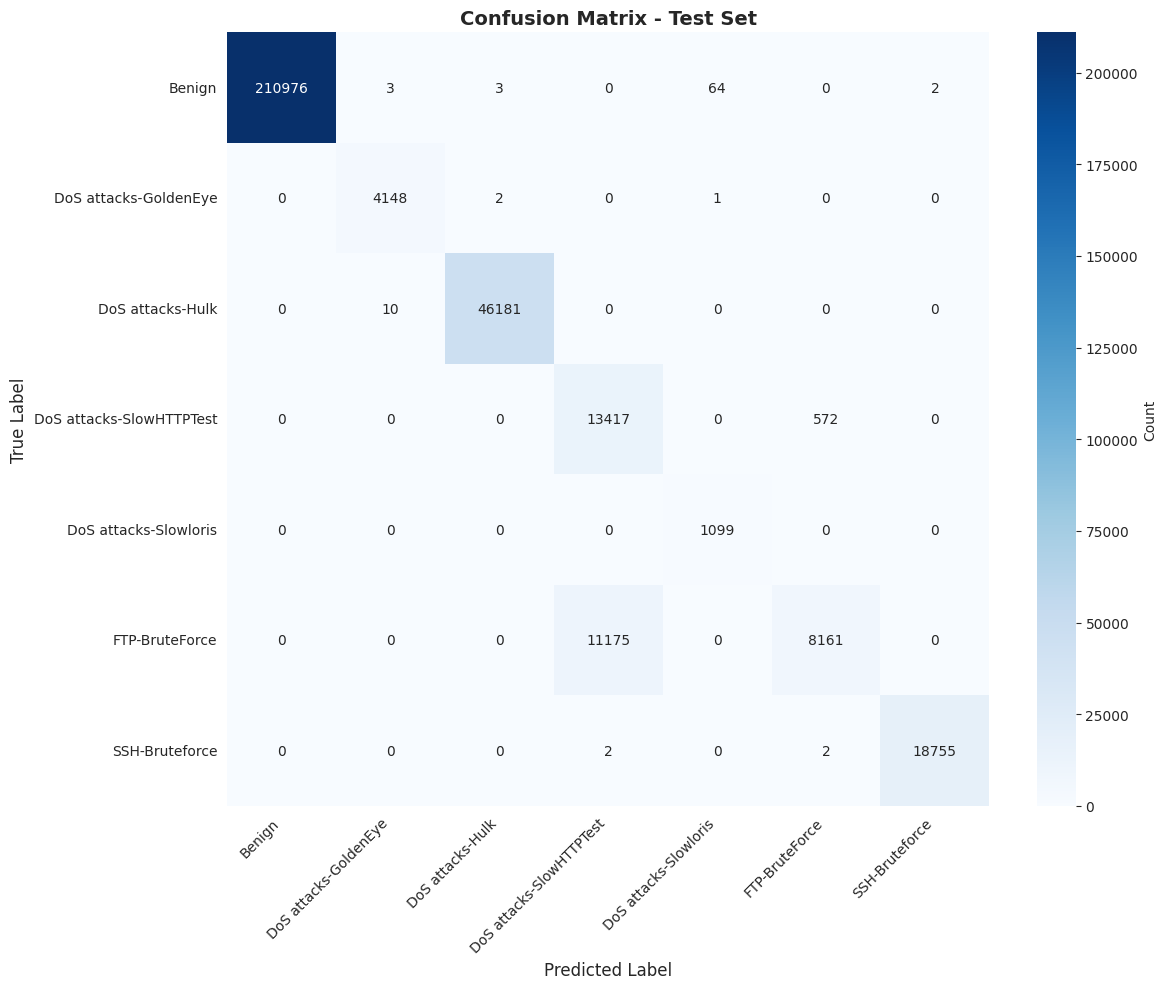

✓ Confusion matrix saved as 'confusion_matrix.png'


In [18]:
# Get detailed predictions for confusion matrix visualization
trained_model.eval()
all_preds, all_labels = [], []

with torch.inference_mode():
    for samples, labels in test_loader:
        samples = samples.to(device)
        labels = labels.to(device).long()
        
        predictions = trained_model(samples)
        preds = torch.argmax(predictions, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Visualize confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved as 'confusion_matrix.png'")



Per-Class Performance Metrics:
                   Class  Precision   Recall  F1-Score  Support
                  Benign   1.000000 0.999659  0.999829   211048
   DoS attacks-GoldenEye   0.996876 0.999277  0.998075     4151
        DoS attacks-Hulk   0.999892 0.999784  0.999838    46191
DoS attacks-SlowHTTPTest   0.545540 0.959111  0.695488    13989
   DoS attacks-Slowloris   0.944158 1.000000  0.971277     1099
          FTP-BruteForce   0.934287 0.422062  0.581454    19336
          SSH-Bruteforce   0.999893 0.999787  0.999840    18759


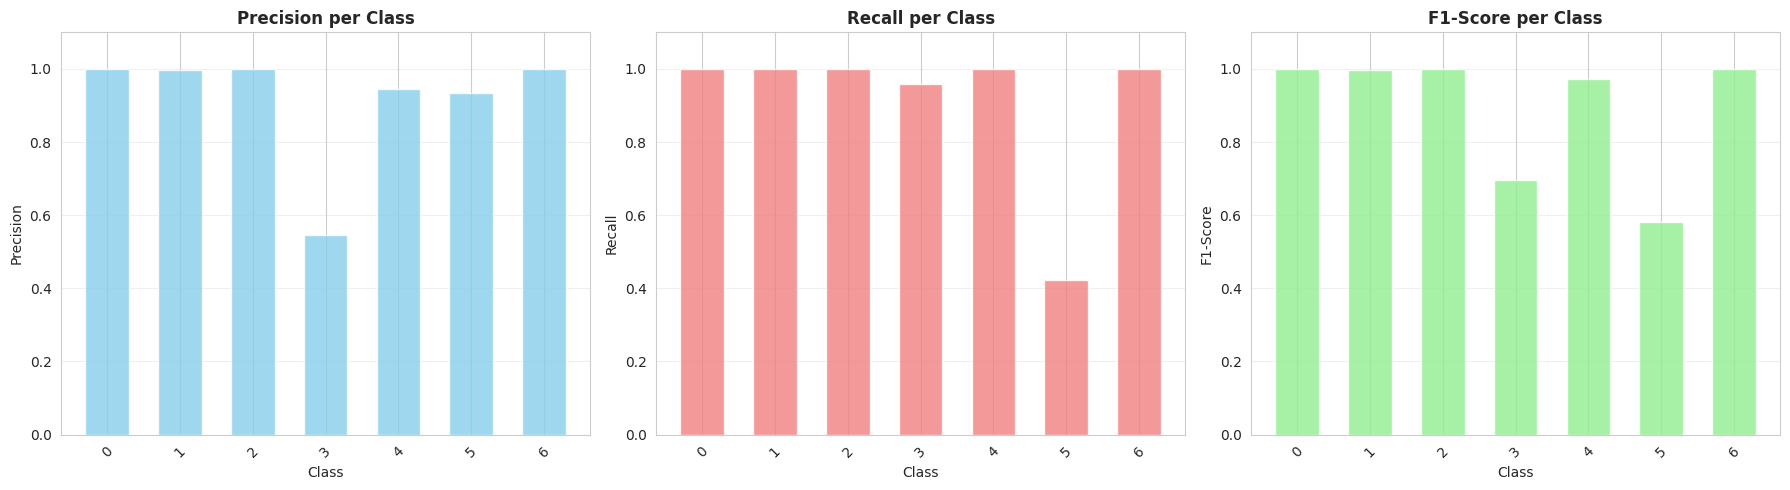

✓ Per-class metrics visualization saved as 'per_class_metrics.png'


In [19]:
# Calculate per-class metrics
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    all_labels, all_preds, labels=range(len(class_names)), zero_division=0
)

# Create metrics dataframe
metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\nPer-Class Performance Metrics:")
print("="*70)
print(metrics_df.to_string(index=False))
print("="*70)

# Visualize per-class metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

x_pos = np.arange(len(class_names))
width = 0.6

axes[0].bar(x_pos, precision, width, color='skyblue', alpha=0.8)
axes[0].set_title('Precision per Class', fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Precision')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([f'{i}' for i in range(len(class_names))], rotation=45)
axes[0].set_ylim([0, 1.1])
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(x_pos, recall, width, color='lightcoral', alpha=0.8)
axes[1].set_title('Recall per Class', fontweight='bold')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Recall')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([f'{i}' for i in range(len(class_names))], rotation=45)
axes[1].set_ylim([0, 1.1])
axes[1].grid(axis='y', alpha=0.3)

axes[2].bar(x_pos, f1, width, color='lightgreen', alpha=0.8)
axes[2].set_title('F1-Score per Class', fontweight='bold')
axes[2].set_xlabel('Class')
axes[2].set_ylabel('F1-Score')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels([f'{i}' for i in range(len(class_names))], rotation=45)
axes[2].set_ylim([0, 1.1])
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('per_class_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Per-class metrics visualization saved as 'per_class_metrics.png'")


## 9. Conclusion {#conclusion}

### Summary of Results

Let's summarize what we learned from this project.


In [20]:
# Final summary
print("\n" + "="*70)
print("PROJECT SUMMARY")
print("="*70)

print(f"\nDataset:")
print(f"  Total training samples: {len(train):,}")
print(f"  Total validation samples: {len(val):,}")
print(f"  Total test samples: {len(test):,}")
print(f"  Number of features: {num_features}")
print(f"  Number of classes: {num_classes}")

print(f"\nModel:")
print(f"  Architecture: {model_name.upper()}")
print(f"  Total parameters: {total_params:,}")

print(f"\nTraining:")
print(f"  Batch size: {config['batch_size']}")
print(f"  Learning rate: {config['learning_rate']}")
print(f"  Epochs: {config['num_epochs']}")
print(f"  Optimizer: AdamW")
print(f"  Loss: Weighted CrossEntropyLoss")

print(f"\nResults:")
print(f"  Test Accuracy: {test_accuracy*100:.2f}%")
print(f"  Best model saved: DL-CIS2018.pth")

print("\n" + "="*70)



PROJECT SUMMARY

Dataset:
  Total training samples: 2,516,579
  Total validation samples: 314,572
  Total test samples: 314,573
  Number of features: 79
  Number of classes: 7

Model:
  Architecture: MLP
  Total parameters: 62,983

Training:
  Batch size: 128
  Learning rate: 0.0001
  Epochs: 10
  Optimizer: AdamW
  Loss: Weighted CrossEntropyLoss

Results:
  Test Accuracy: 96.24%
  Best model saved: DL-CIS2018.pth

